In [26]:
# Import packages

import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Quantization

For the quantization we used **Dynamic Range Quantization**. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point so that the speedup with dynamic-range ops is less than a full fixed-point computation.

Source: [https://www.tensorflow.org/lite/performance/post_training_quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)

In [27]:
converter = tf.lite.TFLiteConverter.from_saved_model('../saved_models/1654016648/')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
tflite_model = converter.convert()

# Convert to Tensorflow Lite Format

In [28]:
tflite_model_file = 'resnet50_ypc_fp32.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

# Try it Out

In [29]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [32]:
img = tf.keras.preprocessing.image.load_img('../sample_images/test3.jpg', target_size=(224, 224)) # Change the img path to your own
x = tf.keras.preprocessing.image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0).astype(np.float32)

interpreter.set_tensor(input_index, x)
interpreter.invoke()
predicted = interpreter.get_tensor(output_index)

In [33]:
classes = [
    'Abyssinian',
    'american_bulldog',
    'american_pit_bull_terrier',
    'basset_hound',
    'beagle',
    'Bengal',
    'Birman',
    'Bombay',
    'boxer',
    'British_Shorthair',
    'chihuahua',
    'Egyptian_Mau',
    'english_cocker_spaniel',
    'english_setter',
    'german_shorthaired',
    'great_pyrenees',
    'havanese',
    'japanese_chin',
    'keeshond',
    'leonberger',
    'Maine_Coon',
    'miniature_pinscher',
    'newfoundland',
    'Persian',
    'pomeranian',
    'pug',
    'Ragdoll',
    'Russian_Blue',
    'saint_bernard',
    'samoyed',
    'scottish_terrier',
    'shiba_inu',
    'Siamese',
    'Sphynx',
    'staffordshire_bull_terrier',
    'wheaten_terrier',
    'yorkshire_terrier']

classes = sorted(classes)
print('Num classes:', len(classes))

Num classes: 37


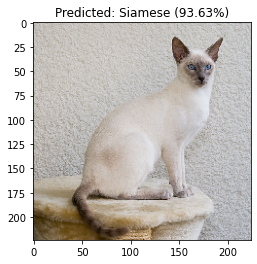

In [34]:
class_predicted = classes[np.argmax(predicted)]
confidence = predicted[0][np.argmax(predicted)] * 100

plt.imshow(img)
plt.title('Predicted: {} ({:.2f}%)'.format(class_predicted, confidence))
plt.show()

# Adding Metadata

In [35]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = 'Resnet50 Your Pet Care Classifier'
model_meta.description = ('Identify type of cats from 37 labels')
model_meta.version = "1"

# Creates input info
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 37 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("../labels.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [36]:
# Creates subgraph info
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [37]:
populator = _metadata.MetadataPopulator.with_model_file('resnet50_ypc_fp32.tflite')
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["../labels.txt"])
populator.populate()